In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier


# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

##Lesson 5.03 & 5.04

In [2]:
reddit = pd.read_csv('./data/reddit_posts.csv')

In [3]:
reddit.head()

,Unnamed: 0,subreddit,title
0,0,CODVanguard,|Vanguard vs BF2042| It´s decided: I´ll go wit...
1,1,CODVanguard,Does anyone recognize any of these guns? These...
2,2,CODVanguard,It's official everyone sledgehammer is indeed ...
3,3,CODVanguard,"Do you think melee, riot shields, and launcher..."
4,4,CODVanguard,To nathan45w


In [4]:
##Drop Unnamed column
reddit.drop(columns=['Unnamed: 0'], inplace= True)

In [5]:
##Binarize subreddit into new column "target"
reddit['target'] = [1 if value == 'CODVanguard' else 0 for value in reddit['subreddit']]

In [6]:
##Initialize Regexp
tokenizer_1 = RegexpTokenizer(r'\w+')

In [7]:
##Create a new column with list of tokenized words
reddit['tokenized title'] = [tokenizer_1.tokenize(post.lower()) for post in reddit['title']]

In [8]:
##Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [105]:
##Create a stopwords list with a few of the low hanging fruit words removed
stopwords_full = stopwords.words('english')
stopwords_full.extend(["vanguard", "cod", "call", "duty", "bf", "2042", "battlefield", "battlefield2024", "bf2042"])

False

In [67]:
##Create a sentence of lemmatized words, then join them as a new lemmatized title
lemma_title = []
for row in reddit['tokenized title']:
    lemma_sent = []
    for word in row:
        if word not in stopwords_full:
            lemma_sent.append(lemmatizer.lemmatize(word))
    lemma_title.append(' '.join(lemma_sent))

In [68]:
##Add lemmatized title as new column
reddit['lemma_title'] = lemma_title

In [69]:
##Do the same with stemmed title
p_stemmer = PorterStemmer()

In [70]:
stem_title = []
for row in reddit['tokenized title']:
    stem_sent = []
    for word in row:
        if word not in stopwords_full:
            stem_sent.append(p_stemmer.stem(word))
    stem_title.append(' '.join(stem_sent))

In [71]:
reddit['stem_title'] = stem_title

In [72]:
##Add column for title character length
reddit['title_char_length'] = reddit['title'].map(len)

In [73]:
##Add column for title word count
reddit['title_word_count'] = [len(value.split()) for value in reddit['title']]

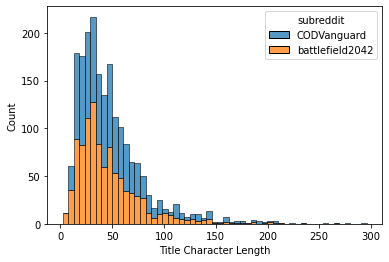

In [106]:
sns.histplot(data= reddit, x = 'title_char_length', hue= 'subreddit', multiple= 'stack')
plt.xlabel("Title Character Length");

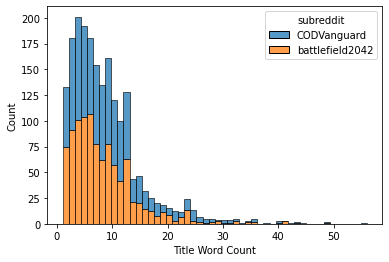

In [107]:
sns.histplot(data= reddit, x = 'title_word_count', hue= 'subreddit', multiple= 'stack')
plt.xlabel("Title Word Count");

<AxesSubplot:>

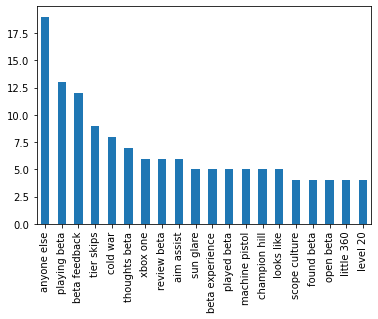

In [76]:
cod = reddit.loc[reddit['subreddit'] == 'CODVanguard', :]

cv = CountVectorizer(stop_words= stopwords_full, min_df= 3, ngram_range=(2,2))
cv.fit(cod['title'])

title_cv = cv.transform(cod['title'])
title_df = pd.DataFrame(title_cv.todense(), columns = cv.get_feature_names())
title_df.sum().sort_values(ascending= False).head(20).plot(kind = 'bar')

<AxesSubplot:>

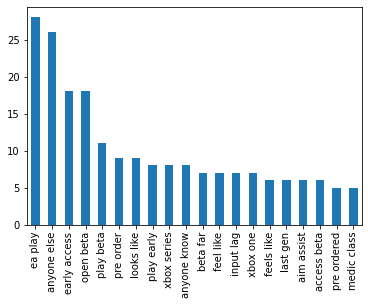

In [77]:
bf = reddit.loc[reddit['subreddit'] == 'battlefield2042', :]

cv = CountVectorizer(stop_words= stopwords_full, min_df= 3, ngram_range=(2,2))
cv.fit(bf['title'])

title_cv = cv.transform(bf['title'])
title_df = pd.DataFrame(title_cv.todense(), columns = cv.get_feature_names())
title_df.sum().sort_values(ascending= False).head(20).plot(kind = 'bar')

In [78]:
## Dataframe to compare models
df_compare = pd.DataFrame(columns=['Column Used', 'Best Estimator', 'Train Score', 'Test Score',
                                        'True Positive', 'True Negative', 'False Positive', 'False Negative'])

## Start Iteration

In [205]:
##View options for corpus
reddit.columns

Index(['subreddit', 'title', 'target', 'tokenized title', 'lemma_title',
       'stem_title', 'title_char_length', 'title_word_count'],
      dtype='object')

In [206]:
##Pick title for corpus, then click the cell above, then click "Cell" >> "Run All Below"
corpus = 'title'

In [207]:
X = reddit[corpus]
y = reddit['target']

In [208]:
##View baseline
y.value_counts(normalize = True)

0    0.5
1    0.5
Name: target, dtype: float64

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

## CVEC

In [210]:
cvec = CountVectorizer()
cvec.fit(X_train)

CountVectorizer()

In [211]:
##Create pipeline with CVEC and Multinomial NB
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [212]:
##Set gridsearch params
pipe_params = {
    'cvec__max_features': [1_000, 1_500, 2_000],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [.3, .4, .5],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}

##Lesson 5.03 & 5.04

In [213]:
##Create grid search
gs_cvec = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)

In [214]:
##Fit grid search
gs_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.3, 0.4, 0.5],
                         'cvec__max_features': [1000, 1500, 2000],
                         'cvec__min_df': [1, 2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [215]:
# What're the best params?
print(gs_cvec.best_params_)

{'cvec__max_df': 0.4, 'cvec__max_features': 1500, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}


In [216]:
# Get predictions
preds = gs_cvec.predict(X_test)

In [217]:
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

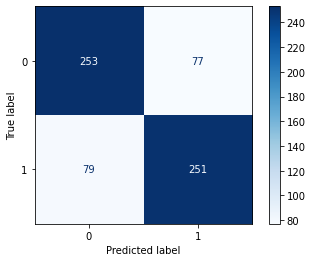

In [218]:
# View confusion matrix
plot_confusion_matrix(gs_cvec, X_test, y_test, cmap='Blues', values_format='d');

In [219]:
##Get values ready for dataframe
row_dict_cvec = {
    'Column Used' : [corpus],
    'Best Estimator' : [gs_cvec.best_estimator_],
    'Train Score' : [gs_cvec.score(X_train, y_train)],
    'Test Score' : [gs_cvec.score(X_test, y_test)],
    'True Positive' : [tp],
    'True Negative' : [tn],
    'False Positive' : [fp],
    'False Negative' : [fn]
}

## from https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi

### TVEC

In [220]:
##Do same for TVEC and Multinomial NB
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
##Lesson 5.03 & 5.04

In [221]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}
##Lesson 5.03 & 5.04

In [222]:
gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params,
                        cv=5) 
##Lesson 5.03 & 5.04

In [223]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [224]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

In [ ]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

In [225]:
row_dict_tvec = {
    'Column Used' : [corpus],
    'Best Estimator' : [gs_tvec.best_estimator_],
    'Train Score' : [gs_tvec.score(X_train, y_train)],
    'Test Score' : [gs_tvec.score(X_test, y_test)],
    'True Positive' : [tp],
    'True Negative' : [tn],
    'False Positive' : [fp],
    'False Negative' : [fn]
}

## Random Forest

In [226]:
##Do the same for CVEC, TFIDF, & RANDOM FOREST
cvec_idf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf' , TfidfTransformer()),
    ('rf', RandomForestClassifier())
])

pipe_params_cidf = {
        'cvec__max_features' : [1500, 1800, 2000, 2100],
        'cvec__ngram_range' : [(1, 3), (1, 2)],
        'cvec__min_df' : [4, 5, 6],
        'tfidf__use_idf': [True, False]
}


# Instantiate GridSearchCV.
gs_cvec_idf = GridSearchCV(cvec_idf_pipe,
                      param_grid=pipe_params_cidf,
                      cv=5,
                      verbose=1)



# Fit GridSearch to training data.
gs_cvec_idf.fit(X_train, y_train)

##Lesson 5.03 & 5.04

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_features': [1500, 1800, 2000, 2100],
                         'cvec__min_df': [4, 5, 6],
                         'cvec__ngram_range': [(1, 3), (1, 2)],
                         'tfidf__use_idf': [True, False]},
             verbose=1)

In [227]:
# Get predictions
preds_gs_cvec_idf = gs_cvec_idf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_gs_cvec_idf).ravel()

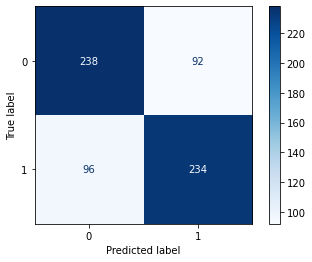

In [228]:
plot_confusion_matrix(gs_cvec_idf, X_test, y_test, cmap='Blues', values_format='d');

In [229]:
row_dict_gs_cvec_idf = {
    'Column Used' : [corpus],
    'Best Estimator' : [gs_cvec_idf.best_estimator_],
    'Train Score' : [gs_cvec_idf.score(X_train, y_train)],
    'Test Score' : [gs_cvec_idf.score(X_test, y_test)],
    'True Positive' : [tp],
    'True Negative' : [tn],
    'False Positive' : [fp],
    'False Negative' : [fn]
}

## Add rows to comparison Dataframe

In [230]:
## Convert dictionaries to Datframes
add_row_cvec = pd.DataFrame(row_dict_cvec)
add_row_tvec = pd.DataFrame(row_dict_tvec)
add_row_gs_cvec_idf = pd.DataFrame(row_dict_gs_cvec_idf)

In [231]:
## Add rows to comparison dataframe
df_compare = pd.concat([df_compare, add_row_tvec, add_row_cvec, add_row_gs_cvec_idf])

## Stop Iteration

In [233]:
##Comment these until final run for maximum eff.
df_compare.reset_index(drop=True, inplace=True)

In [238]:
##Comment these out until the end for maximum eff.
df_compare.to_csv('./data/compare_models.csv')